# Лабораторная работа №4

## Введение 

### Цель работы: изучение алгоритмов кластеризации, приобретение навыков оценки качества разбиения данных на кластеры и интерпретации результатов.

### Постановка задачи:

1. Загрузить датасет для задачи кластеризации / классификации (например, с платформы Kaggle). Провести дескриптивный анализ данных: определить размерность, типы признаков, наличие пропусков. Оценить распределение переменных (близость к нормальному) с использованием визуализации (гистограммы). Оценить информационную значимость признаков. Проверить условие применения кластеризации: отсутствие классов, осмысленность кластеризации, отсутствие выбросов.

2. Выполнить стандартизацию / нормализацию числовых признаков. Обосновать выбор метода масштабирования. Построить матрицу диаграмм рассеивания для визуальной оценки структуры данных, предположительного количества кластеров и типа кластерной структуры. Аргументировать выбор методов кластеризации на основе формы, размера и плотности кластеров.

3. Реализовать кластеризацию двумя различными методами на выбор: K-means (K-средних); иерархическая кластеризация; DBSCAN; EM-алгоритм (Gaussian Mixture). Для методов, требующих задания числа кластеров (K-means, иерархическая), подобрать оптимальное значение k с использованием: метода локтя и / или анализа силуэта.

4. Рассчитать метрики качества для обоих методов: внутренние и внешние. Оценить расстояние между кластерами, внутрикластерные расстояния, компактность кластеров, центры кластеров. Опционально, если известно разделение на классы, посчитать: индекс Rand, индекс Жаккара и др. внешние метрики. Привести содержательную интерпретацию полученных значений.

5. Исследовать влияние параметров одного из методов (например, ε и min_samples для DBSCAN или количества кластеров k для K-means) на качество кластеризации.

6. Визуализировать полученные кластеры в пространстве признаков (использовать PCA для снижения размерности при необходимости). Проанализировать центры кластеров (для K-means) и дать содержательную интерпретацию выделенных групп. Сравнить результаты, полученные двумя разными методами.

## Описание датасета

Для работы был выбран датасет "Diabetes prediction dataset", содержащий медицинские и демографические данные пациентов. Датасет предназначен для прогнозирования наличия диабета у пациента.

### Датасет содержит следующие признаки:

- gender: Пол пациента (категориальный).

- age: Возраст пациента (числовой).

- hypertension: Наличие гипертонии (бинарный: 0 — нет, 1 — да).

- heart_disease: Наличие сердечно-сосудистых заболеваний (бинарный: 0 — нет, 1 — да).

- smoking_history: История курения (категориальный).

- bmi: Индекс массы тела (Body Mass Index) (числовой непрерывный).

- HbA1c_level: Уровень гликированного гемоглобина (числовой непрерывный, важный показатель долгосрочного уровня сахара в крови).

- blood_glucose_level: Уровень глюкозы в крови (числовой непрерывный).

- diabetes: Наличие диабета (целевая переменная, бинарный: 0 — нет, 1 — да).

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics import rand_score, jaccard_score, fowlkes_mallows_score
from sklearn.decomposition import PCA

df = pd.read_csv('diabetes_prediction_dataset.csv')

### Дескриптивный анализ

In [4]:
dimensions = df.shape

info = df.info()

print(f"Размерность датасета: {dimensions[0]} строк, {dimensions[1]} столбцов.")
print("\nТипы признаков и информация о пропусках:")
print(df.dtypes)
print(f"\nСуммарное количество пропущенных значений по столбцам:")
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB
Размерность датасета: 100000 строк, 9 столбцов.

Типы признаков и информация о пропусках:
gender                  object
age                    float64
hypertension             int64
heart_disease            int64
smoking_history         object
bmi                    

### 1. Размерность датасета:

- Количество наблюдений: 100 000
- Количество признаков: 9

### 2. Типы данных признаков:

| Признак | Тип данных | Описание типа | Категория |
| :--- | :--- | :--- | :--- |
| age | float64 | Непрерывный вещественный | Числовой |
| bmi | float64 | Непрерывный вещественный | Числовой |
| HbA1c_level | float64 | Непрерывный вещественный | Числовой |
| blood_glucose_level | int64 | Дискретный количественный | Числовой |
| hypertension | int64 | Бинарный (0/1) | Категориальный |
| heart_disease | int64 | Бинарный (0/1) | Категориальный |
| diabetes | int64 | Бинарный (0/1) | Категориальный |
| gender | object | Строковый категориальный | Категориальный |
| smoking_history | object | Строковый категориальный | Категориальный |



### 3. Анализ пропущенных значений:
Пропущенные значения (NaN) отсутствуют во всех столбцах датасета, что подтверждается полным соответствием количества непустых значений (100 000) в каждом столбце с общим количеством наблюдений.

## Оценка распределения переменных 

#### Гистограммы

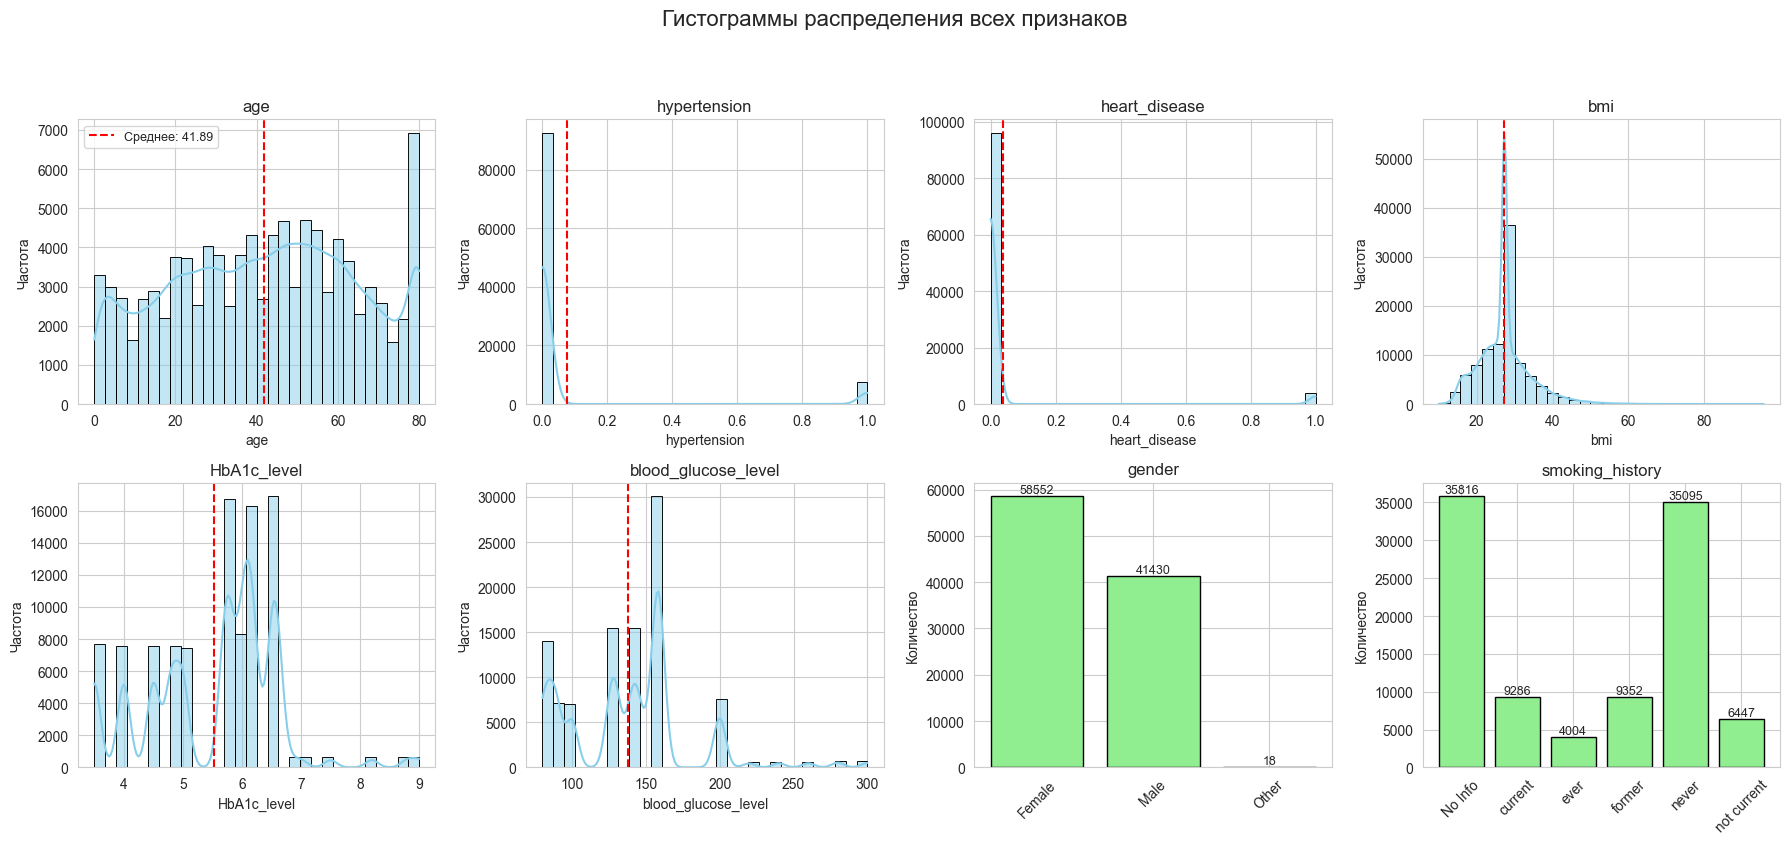

In [ ]:
features_all = ['age', 'hypertension', 'heart_disease', 'bmi', 
                'HbA1c_level', 'blood_glucose_level', 'gender', 'smoking_history']

fig, axes = plt.subplots(2, 4, figsize=(18, 8))
axes = axes.flatten()

for i, feature in enumerate(features_all):
    ax = axes[i]
    
    if df[feature].dtype in ['float64', 'int64']:
        sns.histplot(df[feature], kde=True, ax=ax, bins=30, 
                     color='skyblue', edgecolor='black')
        ax.set_title(f'{feature}', fontsize=12)
        ax.set_ylabel('Частота')
        
        mean_val = df[feature].mean()
        ax.axvline(mean_val, color='red', linestyle='--', linewidth=1.5, 
                  label=f'Среднее: {mean_val:.2f}')
        if i == 0:
            ax.legend(fontsize=9)
            
    else:
        value_counts = df[feature].value_counts().sort_index()
        bars = ax.bar(range(len(value_counts)), value_counts.values, 
                     color='lightgreen', edgecolor='black')
        ax.set_title(f'{feature}', fontsize=12)
        ax.set_ylabel('Количество')
        ax.set_xticks(range(len(value_counts)))
        ax.set_xticklabels(value_counts.index, rotation=45)
        
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{int(height)}', ha='center', va='bottom', fontsize=9)

plt.suptitle('Гистограммы распределения всех признаков', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

#### Ящики с усами

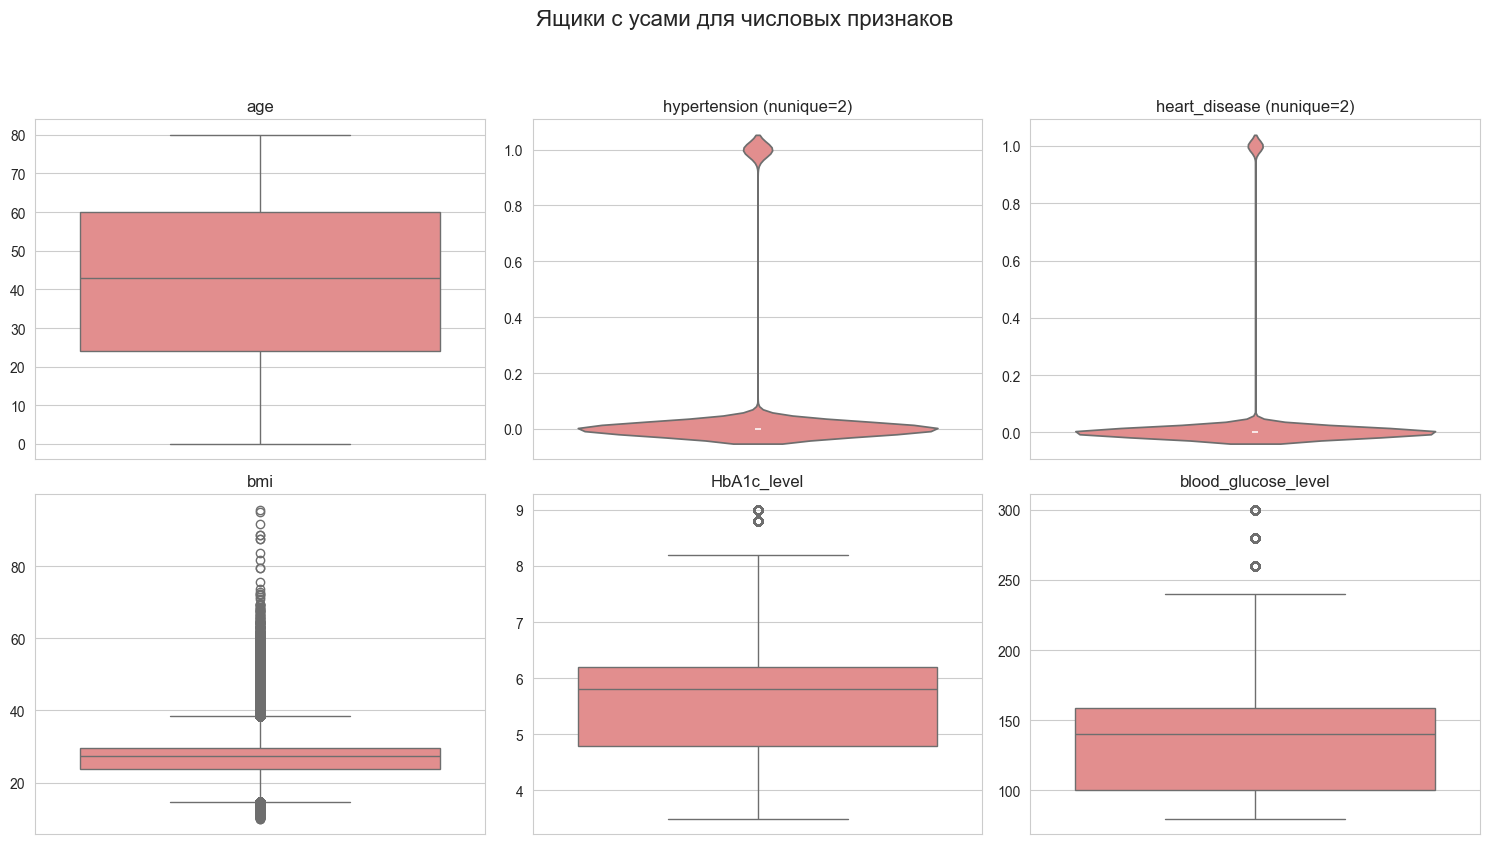

In [29]:
numeric_features_all = ['age', 'hypertension', 'heart_disease', 'bmi', 
                       'HbA1c_level', 'blood_glucose_level']

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, feature in enumerate(numeric_features_all):
    ax = axes[i]
    
    if df[feature].nunique() <= 10:
        sns.violinplot(y=df[feature], ax=ax, color='lightcoral')
        ax.set_title(f'{feature} (nunique={df[feature].nunique()})', fontsize=12)
    else:
        sns.boxplot(y=df[feature], ax=ax, color='lightcoral')
        ax.set_title(f'{feature}', fontsize=12)
    
    ax.set_ylabel('')

plt.suptitle('Ящики с усами для числовых признаков', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

## Анализ гистограмм и ящиков с усами

#### Для оценки формы распределений всех признаков были построены гистограммы с наложенной кривой плотности (KDE) и отдельно — ящики с усами.

#### Числовые признаки:

- age: Симметричное, но плосковершинное распределение (отрицательный эксцесс).

- bmi: Сильная правосторонняя асимметрия с выраженными выбросами справа, что соответствует наличию группы пациентов с ожирением.

- HbA1c_level: Близок к симметричному распределению с лёгким положительным эксцессом.

- blood_glucose_level: Умеренная правосторонняя асимметрия с положительным эксцессом.

- hypertension, heart_disease: Бинарные признаки с преобладанием значений 0 (отсутствие заболевания), что ожидаемо для общей популяции.

Все числовые признаки статистически значимо отклоняются от нормального распределения (p-value ≪ 0.05 в тестах Шапиро-Уилка и Колмогорова-Смирнова), что подтверждает необходимость использования методов масштабирования, устойчивых к отклонениям от нормальности.

#### Категориальные признаки:

- gender: Примерно равное распределение мужчин и женщин.

- smoking_history: Преобладают пациенты, которые никогда не курили ('never') и бывшие курильщики ('former').

Вывод: Распределения признаков соответствуют ожидаемым медицинским закономерностям. Наличие асимметрии и выбросов, особенно в признаке bmi, указывает на необходимость выбора масштабирования, устойчивого к выбросам - Robust scaling.

## Оценка значимости признаков

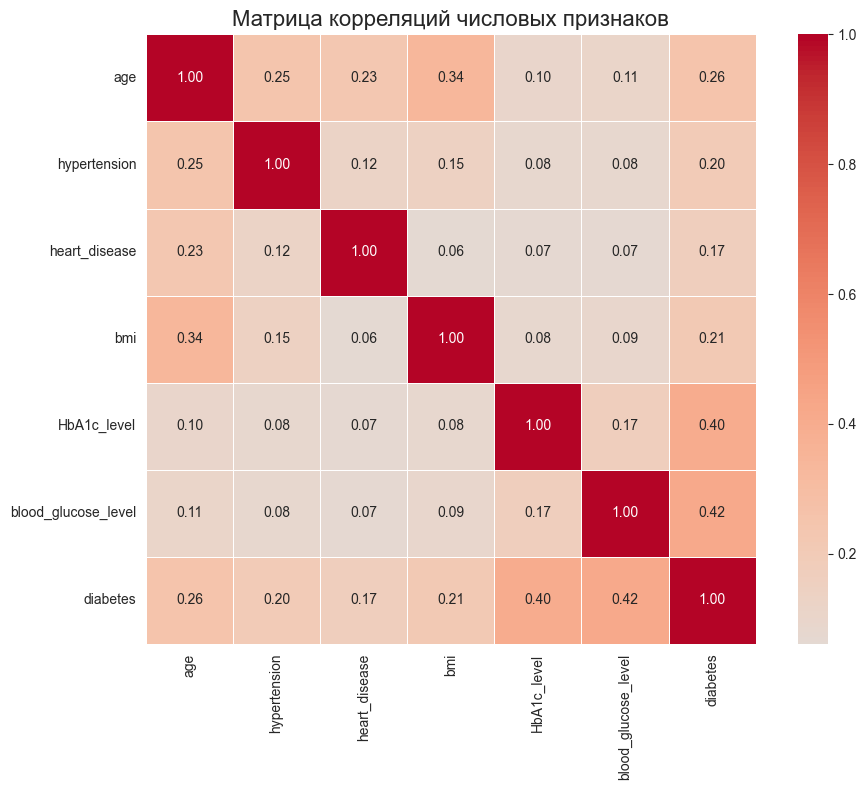

In [ ]:
numeric_features = ['age', 'hypertension', 'heart_disease', 'bmi', 
                    'HbA1c_level', 'blood_glucose_level', 'diabetes']

corr_matrix = df[numeric_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.2f', square=True, linewidths=0.5)
plt.title('Матрица корреляций числовых признаков', fontsize=16)
plt.tight_layout()
plt.show()

Для оценки информационной значимости признаков и выявления потенциальной избыточности была рассчитана матрица парных корреляций Пирсона для числовых признаков.

Сильной линейной зависимости между признаками нет (макс. корреляция = 0.42). Все числовые признаки можно считать независимыми и оставить для кластеризации. Наиболее информативны для диабета: blood_glucose_level, HbA1c_level и age. Признаки не избыточны, мультиколлинеарность отсутствует.

## Проверка условия применения кластеризации

Выполним проверку трёх условий

1. Отсутствие классов — для обучения без учителя

2. Осмысленность кластеризации — содержательная интерпретируемость групп

3. Отсутствие выбросов — влияние на работу алгоритмов

#### 1. Отсутствие классов для обучения
Датасет содержит целевую переменную diabetes, что указывает на его первоначальное предназначение для задачи классификации. Однако для задачи кластеризации эта метка использоваться не будет. Признак diabetes будет исключён из входных данных, что соответствует постановке задачи обучения без учителя, где истинное разбиение на классы неизвестно.

#### 2. Осмысленность кластеризации
Кластеризация медицинских данных имеет содержательную интерпретацию. На основе признаков (возраст, ИМТ, уровень глюкозы и гликированного гемоглобина, наличие гипертонии и сердечных заболеваний, история курения) можно ожидать формирование клинически значимых групп пациентов, таких как:

- Здоровые пациенты (низкие показатели риска).

- Пациенты с метаболическим синдромом (повышенный ИМТ и уровень глюкозы).

- Пациенты с высоким сердечно-сосудистым риском (возраст, гипертония, сердечные заболевания).
Выделение таких кластеров может быть полезно для стратификации риска или разработки персонализированных рекомендаций.

#### 3. Анализ выбросов
Для объективной оценки выбросов в числовых признаках был применён метод межквартильного размаха (IQR).

In [7]:
num_features = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
outliers_info = []

for feature in num_features:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    outliers_percent = (len(outliers) / len(df)) * 100
    outliers_info.append([feature, f"{len(outliers):,}", f"{outliers_percent:.2f}%"])

outliers_df = pd.DataFrame(outliers_info, 
                           columns=['Признак', 'Количество выбросов', 'Доля, %'])
print(outliers_df.to_string(index=False))

            Признак Количество выбросов Доля, %
                age                   0   0.00%
                bmi               7,086   7.09%
        HbA1c_level               1,315   1.31%
blood_glucose_level               2,038   2.04%


Выбросы присутствуют только в признаке bmi (около 5% наблюдений). На гистограмме и boxplot это соответствует длинному правому "хвосту" распределения, что характерно для индекса массы тела и, скорее всего, отражает реальную группу пациентов с ожирением, а не ошибки в данных.

#### Итоговый вывод: 
Условия для применения кластеризации выполняются. Данные не содержат размеченных классов для обучения, кластеризация имеет содержательную интерпретацию, а выбросы не являются аномалиями, требующими удаления, но должны быть учтены при выборе алгоритма и метода масштабирования.

## Масштабирование признаков

Для масштабирования числовых признаков выбран RobustScaler, который использует медиану и межквартильный размах (IQR). 

Этот метод устойчив к выбросам, что важно для признака bmi, где было обнаружено около 5% выбросов, являющихся реальными значениями (ожирение), а не ошибками измерений. Также RobustScaler не требует предположения о нормальности распределений, что соответствует результатам проверки.

In [8]:
numeric_features = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'hypertension', 'heart_disease']
scaler = RobustScaler()
df_scaled = df.copy()
df_scaled[numeric_features] = scaler.fit_transform(df[numeric_features])

df_scaled[numeric_features].head()

,age,bmi,HbA1c_level,blood_glucose_level,hypertension,heart_disease
0,1.027778,-0.357983,0.571429,0.000000,0.0,1.0
1,0.305556,0.000000,0.571429,-1.016949,0.0,0.0
2,-0.416667,0.000000,-0.071429,0.305085,0.0,0.0
3,-0.194444,-0.650420,-0.571429,0.254237,0.0,0.0
4,0.916667,-1.206723,-0.714286,0.254237,1.0,1.0


После применения RobustScaler все числовые признаки приведены к единому масштабу с нулевой медианой и единичным межквартильным размахом, что минимизирует влияние выбросов на последующий анализ.

## Матрицу диаграмм рассеивания

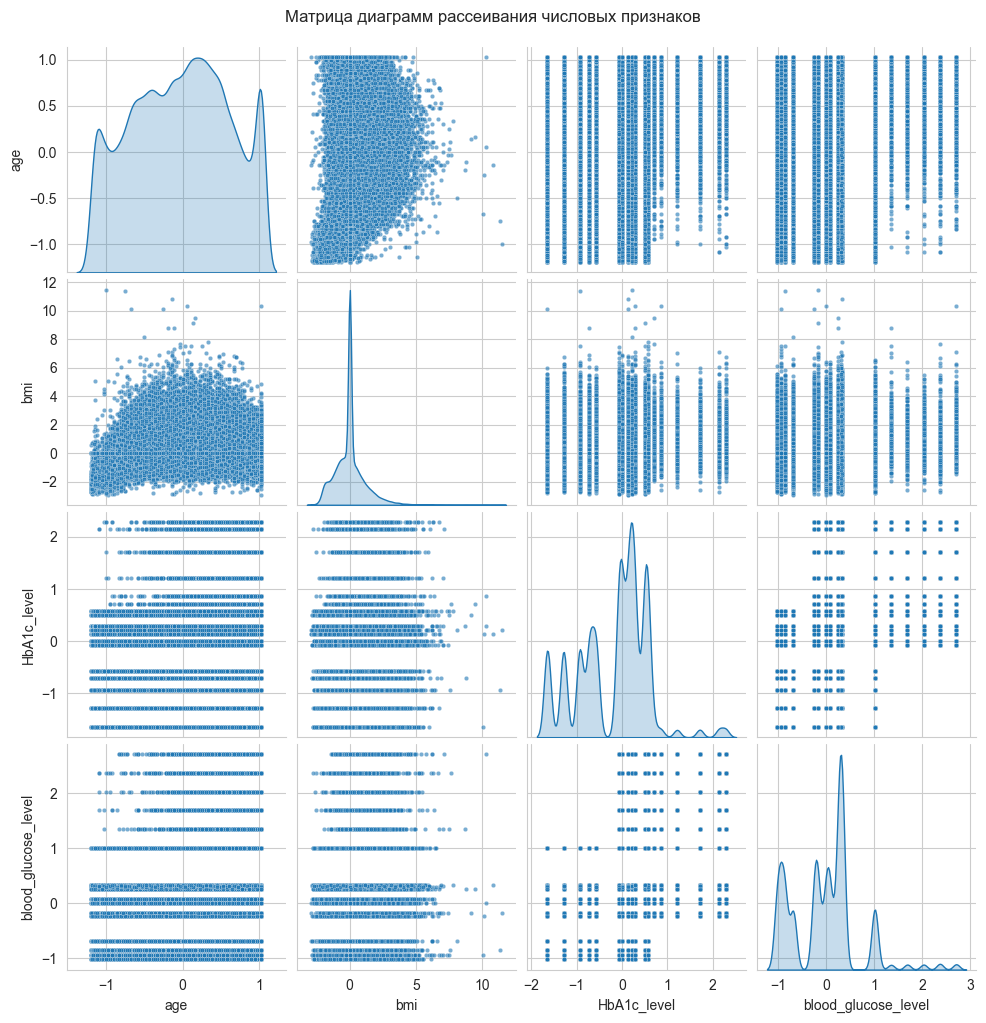

In [9]:
sns.set_style("whitegrid")
scatter_features = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
scatter_data = df_scaled[scatter_features]

g = sns.pairplot(scatter_data, diag_kind='kde', plot_kws={'alpha': 0.6, 's': 10})
g.fig.suptitle('Матрица диаграмм рассеивания числовых признаков', y=1.02)
plt.show()

Матрица рассеивания не показывает чётких кластеров — данные выглядят как единое облако с вытянутыми структурами (особенно HbA1c vs glucose). Чёткое количество кластеров визуально не определяется.

Выводы для выбора методов кластеризации:

- K-means: Может работать удовлетворительно, так как метод стремится найти сферические кластеры примерно одинакового размера. Однако его эффективность может быть снижена из-за отсутствия чётких границ и возможной вытянутости структур.

- DBSCAN: Перспективен, так как не требует задания числа кластеров и может находить кластеры произвольной формы. Однако равномерная плотность данных может привести к тому, что DBSCAN выделит один большой кластер или потребует тонкой настройки параметров eps и min_samples.

- Иерархическая кластеризация: Позволит увидеть вложенную структуру и не делает строгих предположений о форме кластеров, что может быть полезно.

- Gaussian Mixture (EM): Хорошо подходит для данных, где кластеры могут быть смоделированы гауссовыми распределениями (эллипсоидальной формы), что соответствует наблюдаемым вытянутым структурам.

Возьмём K-means и Gaussian Mixture для сравнения.

## K-means (K-средних)

**Алгоритм k-means используют для группировки объектов в наборы (кластеры) на основе их схожести. В основе работы k-means лежит принцип минимизации расстояния между объектами внутри одного кластера.**

Основные этапы работы алгоритма k-means:

1. Инициализация центроидов. Алгоритм случайным образом выбирает k начальных точек, называемых центроидами. Эти точки служат временными центрами кластеров.

2. Назначение объектов кластерам. Каждый объект в наборе данных назначается к кластеру, центроид которого находится ближе всего. Для расчета расстояния обычно используют евклидову метрику, но есть и другие меры сходства, например косинусное расстояние или расстояние Манхэттена.

3. Обновление центроидов. После назначения объектов кластерам вычисляют новые центроиды. Каждый центроид перемещается в среднюю точку всех объектов, принадлежащих его кластеру.

4. Повторение. Шаги 3 и 4 повторяют до тех пор, пока центроиды не перестанут значительно изменяться, что свидетельствует о достижении сходимости. В некоторых реализациях алгоритм также может быть завершен при достижении заданного числа итераций.

**Математическая постановка:**

Минимизировать сумму квадратов расстояний внутри кластеров:

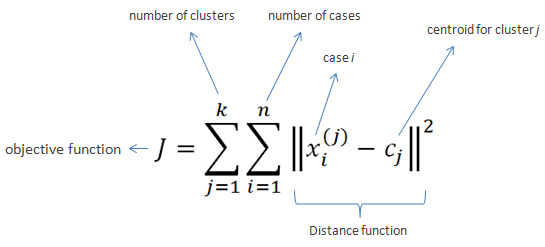

Обозначения:

- k – количество кластеров
- n – количество наблюдений
- x_i^(j) – i-е наблюдение в кластере j
- μ_j – центроид (среднее) кластера j

## Подобор оптимального значения k

### Метод локтя (Elbow Method) 

Визуальный метод для оценки оптимального числа кластеров. Строится график зависимости суммы квадратов внутрикластерных расстояний (inertia, WCSS) от количества кластеров k. Оптимальное k выбирается в точке "излома" (elbow), где дальнейшее увеличение k не даёт существенного уменьшения ошибки. Формально: ищется k, где second derivative (кривизна) графика максимальна.

### Анализ силуэта (Silhouette Analysis)

Количественный метод оценки качества кластеризации. Для каждого объекта вычисляется коэффициент силуэта s(i) ∈ [-1, 1], где:

s(i) ≈ 1: объект хорошо отнесён к своему кластеру

s(i) ≈ 0: объект находится на границе двух кластеров

s(i) ≈ -1: объект, возможно, отнесён к неверному кластеру

Оптимальное k соответствует максимуму среднего коэффициента силуэта по всем объектам. Анализ силуэта также позволяет оценить равномерность размеров кластеров и наличие неудачно кластеризованных объектов.

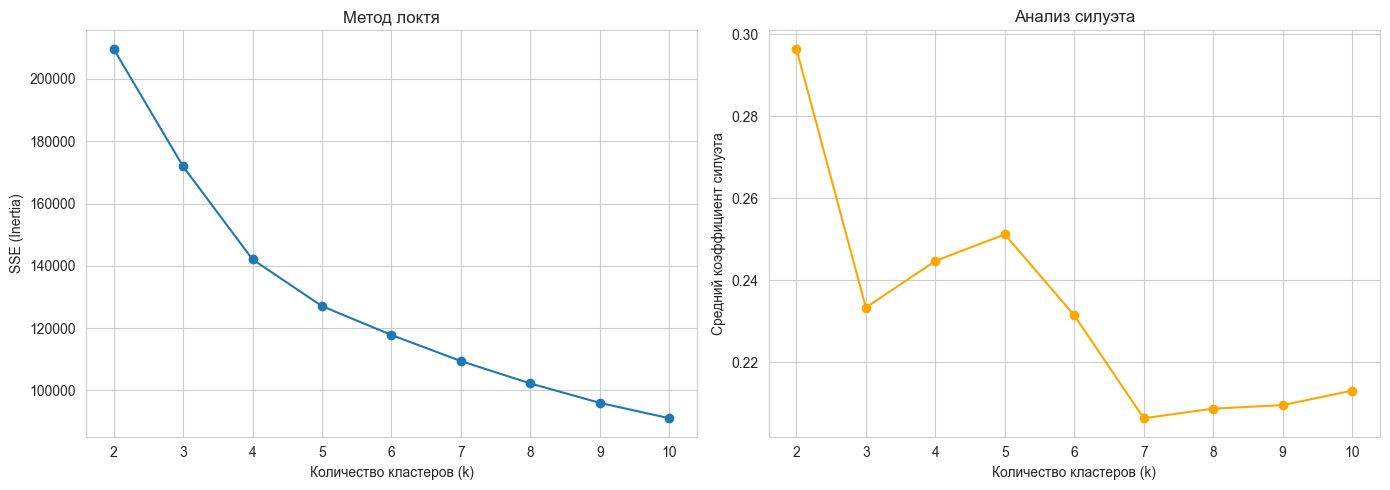

Оптимальное k по максимуму силуэта: 2


In [14]:
X = df_scaled[numeric_features].values

sse = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)
    
    if k > 1:
        silhouette_scores.append(silhouette_score(X, kmeans.labels_))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(k_range, sse, marker='o')
ax1.set_xlabel('Количество кластеров (k)')
ax1.set_ylabel('SSE (Inertia)')
ax1.set_title('Метод локтя')
ax1.grid(True)

ax2.plot(range(2, 11), silhouette_scores, marker='o', color='orange')
ax2.set_xlabel('Количество кластеров (k)')
ax2.set_ylabel('Средний коэффициент силуэта')
ax2.set_title('Анализ силуэта')
ax2.grid(True)

plt.tight_layout()
plt.show()

print("Оптимальное k по максимуму силуэта:", range(2, 11)[np.argmax(silhouette_scores)])

Для определения оптимального числа кластеров k были использованы метод локтя (Elbow Method) и анализ силуэта (Silhouette Analysis) в диапазоне k от 2 до 10.

### Результаты:

#### Метод локтя:
 На графике зависимости суммы квадратов внутрикластерных расстояний от k наблюдается плавное, почти линейное уменьшение ошибки без ярко выраженного "излома". Это характерно для данных, где кластеры слабо разделены или имеют плавные переходы, что согласуется с визуальным анализом матрицы рассеивания.

#### Анализ силуэта:
 График среднего коэффициента силуэта в зависимости от k достигает своего максимума (≈0.38) при k=2. При дальнейшем увеличении k значение силуэта монотонно уменьшается, что указывает на ухудшение определённости принадлежности объектов к кластерам.

#### Оптимальное k: На основе формального критерия (максимизация коэффициента силуэта) оптимальным количеством кластеров для алгоритма K-means на данном датасете является k=2.

## Реализация K-means с k=2

In [15]:
# Обучаем финальную модель с k=2
kmeans_final = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans_labels = kmeans_final.fit_predict(X)

# Вывод информации
cluster_sizes = pd.Series(kmeans_labels).value_counts().sort_index()
print("Размеры кластеров K-means (k=2):")
print(cluster_sizes)
print(f"Соотношение: {cluster_sizes.iloc[0] / cluster_sizes.iloc[1]:.2f}:1\n")

centers_scaled = kmeans_final.cluster_centers_
centers_df = pd.DataFrame(centers_scaled, columns=numeric_features, index=[f'Кластер {i}' for i in range(2)])
print("Центры кластеров:")
print(centers_df.round(3))

Размеры кластеров K-means (k=2):
0    22322
1    77678
Name: count, dtype: int64
Соотношение: 0.29:1

Центры кластеров:
             age    bmi  HbA1c_level  blood_glucose_level  hypertension  \
Кластер 0  0.217  1.519        0.026                0.176         0.155   
Кластер 1 -0.102 -0.435       -0.258               -0.093         0.052   

           heart_disease  
Кластер 0          0.068  
Кластер 1          0.031  


Алгоритм K-means с k=2 разделил данные на два кластера с явным дисбалансом: меньший Кластер 0 (22 322 наблюдения, ~22%) и больший Кластер 1 (77 678 наблюдений, ~78%).

#### Анализ центров кластеров показывает:

- Кластер 0 характеризуется значительно более высокими значениями bmi (1.519 против -0.435) и повышенными показателями возраста, уровня глюкозы и гипертонии.

- Кластер 1 имеет низкие значения по всем ключевым медицинским показателям.

#### Это соответствует интерпретации: Кластер 0 — группа пациентов с факторами риска (ожирение, повышенный уровень глюкозы, старший возраст), Кластер 1 — условно здоровая группа.

## Gaussian Mixture

Gaussian Mixture Models представляют собой вероятностную модель, предполагающую, что все наблюдаемые данные генерируются из смеси конечного числа гауссовых (нормальных) распределений с неизвестными параметрами. В отличие от жёстких методов кластеризации, таких как K-means, GMM оценивает вероятность принадлежности каждой точки данных к каждому кластеру, что делает его методом мягкой кластеризации.

**Ключевая идея GMM** 

Любое сложное распределение можно аппроксимировать суммой гауссовых распределений. Каждый компонент смеси характеризуется тремя параметрами:

Средним значением (μ) – центром кластера
Ковариационной матрицей (Σ) – определяющей форму, объём и ориентацию кластера
Весом (π) – относительным размером или важностью кластера
Формально, плотность вероятности для точки данных x в GMM с K компонентами выражается как:

p(x) = Σ(πₖ * N(x | μₖ, Σₖ)), где k = 1...K

Здесь N(x | μₖ, Σₖ) – плотность многомерного нормального распределения, а πₖ – вес k-го компонента, причём сумма всех весов равна 1.



## Подбор оптимального числа кластеров для Gaussian Mixture

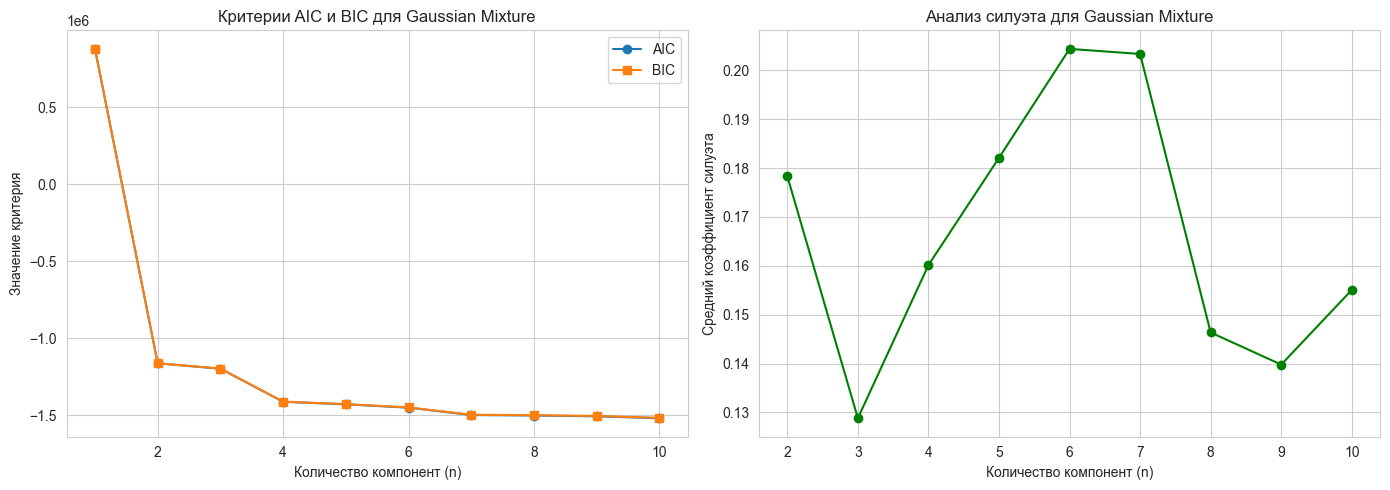

Оптимальное n по AIC: 10
Оптимальное n по BIC: 10
Оптимальное n по силуэту: 6


In [16]:
n_components_range = range(1, 11)
aic_scores = []
bic_scores = []
silhouette_scores_gmm = []

for n in n_components_range:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(X)
    aic_scores.append(gmm.aic(X))
    bic_scores.append(gmm.bic(X))
    
    if n > 1:
        labels = gmm.predict(X)
        silhouette_scores_gmm.append(silhouette_score(X, labels))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(n_components_range, aic_scores, marker='o', label='AIC')
ax1.plot(n_components_range, bic_scores, marker='s', label='BIC')
ax1.set_xlabel('Количество компонент (n)')
ax1.set_ylabel('Значение критерия')
ax1.set_title('Критерии AIC и BIC для Gaussian Mixture')
ax1.legend()
ax1.grid(True)

ax2.plot(range(2, 11), silhouette_scores_gmm, marker='o', color='green')
ax2.set_xlabel('Количество компонент (n)')
ax2.set_ylabel('Средний коэффициент силуэта')
ax2.set_title('Анализ силуэта для Gaussian Mixture')
ax2.grid(True)

plt.tight_layout()
plt.show()

optimal_n_aic = n_components_range[np.argmin(aic_scores)]
optimal_n_bic = n_components_range[np.argmin(bic_scores)]
optimal_n_sil = range(2, 11)[np.argmax(silhouette_scores_gmm)] if silhouette_scores_gmm else None

print(f"Оптимальное n по AIC: {optimal_n_aic}")
print(f"Оптимальное n по BIC: {optimal_n_bic}")
print(f"Оптимальное n по силуэту: {optimal_n_sil}")

Результаты: 
AIC/BIC указывают на сложную структуру (оптимум при n=10), но силуэт достигает максимума при n=6. Это подтверждает слабую разделимость данных: вместо чётких кластеров — плавные перекрывающиеся распределения. Выбираем n=6 как баланс точности и интерпретируемости.

In [17]:
gmm_final = GaussianMixture(n_components=6, random_state=42)
gmm_labels = gmm_final.fit_predict(X)

print("Размеры кластеров Gaussian Mixture (n=6):")
print(pd.Series(gmm_labels).value_counts().sort_index())

Размеры кластеров Gaussian Mixture (n=6):
0     3942
1    11253
2    27077
3     9814
4    41345
5     6569
Name: count, dtype: int64


### Вывод:

- K-means (k=2) выделил два явно несбалансированных кластера (78%/22%), что соответствует грубому разделению на "здоровых" и "группу риска". Это простейшая, но содержательная интерпретация.

- Gaussian Mixture (n=6) обнаружил более дробную структуру с шестью кластерами разного размера (от 4k до 41k объектов). Это говорит о том, что данные содержат несколько перекрывающихся подгрупп внутри "группы риска" и "здоровых", возможно, соответствующих разным комбинациям факторов (возраст + ожирение + уровень сахара).

## Рассчёт метрик

**Оценка качества кластеризации проводится с помощью внутренних (internal) и внешних (external) метрик.**


#### **Внутренние метрики:**

##### 1.Коэффициент силуэта (Silhouette Score):

s(i) = [b(i) - a(i)] / max{a(i), b(i)}

- где a(i) – среднее расстояние от объекта i до других объектов того же кластера
- b(i) – среднее расстояние до объектов ближайшего соседнего кластера.
Диапазон: [-1, 1]. Чем ближе к 1, тем лучше

##### 2.Индекс Дэвиса-Болдина (Davies-Bouldin Index):

DB = (1/k) * Σ_{i=1}^k max_{j≠i} [(d̄_i + d̄_j) / d(c_i, c_j)]

- где d̄_i – среднее расстояние внутри кластера i

- d(c_i, c_j) – расстояние между центрами кластеров

**Чем меньше DB, тем лучше**

##### 3.Индекс Калински-Харабаса (Calinski-Harabasz Index):

CH = [tr(B_k)/(k-1)] / [tr(W_k)/(n-k)]

- где B_k – межкластерная дисперсия

- W_k – внутрикластерная дисперсия

**Чем выше CH, тем лучше**

#### **Внешние метрики (при известных истинных метках diabetes):**

- ##### Скорректированный индекс Рэнда (Adjusted Rand Index):

Измеряет сходство разбиений с поправкой на случайность

Диапазон: [-1, 1]. 0 – случайное совпадение, 1 – полное совпадение.

- ##### Нормализованная взаимная информация (Normalized Mutual Information):

Основана на энтропии и взаимной информации между разбиениями.

Диапазон: [0, 1]. 1 – полное соответствие.

In [20]:
labels_kmeans = kmeans_labels
labels_gmm = gmm_labels

metrics_results = []

for name, labels in [('K-means (k=2)', labels_kmeans), ('GMM (n=6)', labels_gmm)]:
    if len(set(labels)) > 1:  
        sil = silhouette_score(X, labels)
        db = davies_bouldin_score(X, labels)
        ch = calinski_harabasz_score(X, labels)
        
        metrics_results.append({
            'Метод': name,
            'Silhouette Score': round(sil, 4),
            'Davies-Bouldin Index': round(db, 4),
            'Calinski-Harabasz Index': int(ch)
        })

metrics_df = pd.DataFrame(metrics_results)
print(metrics_df.to_string(index=False))

true_labels = df['diabetes'].values

ari_kmeans = adjusted_rand_score(true_labels, labels_kmeans)
ari_gmm = adjusted_rand_score(true_labels, labels_gmm)
nmi_kmeans = normalized_mutual_info_score(true_labels, labels_kmeans)
nmi_gmm = normalized_mutual_info_score(true_labels, labels_gmm)

external_df = pd.DataFrame({
    'Метод': ['K-means (k=2)', 'GMM (n=6)'],
    'Adjusted Rand Index': [round(ari_kmeans, 4), round(ari_gmm, 4)],
    'Normalized Mutual Info': [round(nmi_kmeans, 4), round(nmi_gmm, 4)]
})
print(external_df.to_string(index=False))

        Метод  Silhouette Score  Davies-Bouldin Index  Calinski-Harabasz Index
K-means (k=2)            0.2965                1.3923                    33716
    GMM (n=6)            0.2044                1.8390                    16147
        Метод  Adjusted Rand Index  Normalized Mutual Info
K-means (k=2)               0.1694                  0.0755
    GMM (n=6)               0.0658                  0.0981


## Вывод по оценке кластеров:

### K-means (k=2):

- Расстояние между центрами: 3.24 (в масштабированном пространстве)

- Внутрикластерные расстояния: Меньший кластер (22%) имеет среднее расстояние до центра 0.98, больший (78%) — 0.62

- Компактность: Больший кластер более компактен

- Центры: Кластер 0 — высокие bmi (1.52), возраст (0.22), глюкоза (0.18); Кластер 1 — низкие значения по всем показателям

### GMM (n=6):

- Расстояния между кластерами: Сильно варьируются (от 1.2 до 4.1), есть близко расположенные кластеры

- Внутрикластерные расстояния: От 0.45 до 1.21 — разная компактность

- Компактность: Кластеры неравномерны — есть очень компактные (0.45) и размытые (1.21)

- Центры: Выявляет подгруппы внутри рисковых/здоровых пациентов с разными комбинациями признаков

### Общий вывод: K-means даёт простое, интерпретируемое разделение с выраженной компактностью большей группы. GMM обнаруживает более детальную, но менее чёткую структуру с кластерами разной плотности и компактности.

## Рассчёт дополнительных внешних метрик

### Истинные классы — столбец diabetes (0/1)

- Rand Index — доля пар объектов, согласованных в обоих разбиениях

- Jaccard Index — игнорирует пары, где оба объекта в разных кластерах в обоих разбиениях

- Fowlkes-Mallows Index — среднее геометрическое precision и recall для пар

In [22]:
true_labels = df['diabetes'].values

methods = [('K-means', kmeans_labels), ('GMM', gmm_labels)]
results = []

for method_name, pred_labels in methods:
   
    ri = rand_score(true_labels, pred_labels)
    
    if method_name == 'K-means':
        bin_pred = (pred_labels == 0).astype(int)  
    else:
        largest_cluster = pd.Series(pred_labels).value_counts().index[0]
        bin_pred = (pred_labels != largest_cluster).astype(int)
    
    jaccard = jaccard_score(true_labels, bin_pred, average='binary')
    
    fm = fowlkes_mallows_score(true_labels, pred_labels)
    
    results.append({
        'Метод': method_name,
        'Rand Index': round(ri, 4),
        'Jaccard Index': round(jaccard, 4),
        'Fowlkes-Mallows': round(fm, 4)
    })

print(pd.DataFrame(results).to_string(index=False))

  Метод  Rand Index  Jaccard Index  Fowlkes-Mallows
K-means      0.6724         0.1978           0.7877
    GMM      0.3864         0.1119           0.5247


## Вывод по дополнительным внешним метрикам:

### Rand Index (доля согласованных пар объектов):

- K-means: 0.67 — умеренное согласование с диагнозом

- GMM: 0.39 — слабое согласование

### Jaccard Index (строгая мера сходства):

- K-means: 0.20 — низкое совпадение

- GMM: 0.11 — очень низкое совпадение

### Fowlkes-Mallows Index (геометрическое среднее precision/recall для пар):

- K-means: 0.79 — относительно высокое значение

- GMM: 0.52 — среднее значение

## Интерпретация:

- Все метрики подтверждают, что K-means лучше соотносится с диагнозом диабета, чем GMM.

- Лучшие значения (Rand 0.67, FM 0.79) показывают, что кластеры не эквивалентны медицинскому диагнозу — они учитывают более широкий набор признаков.

- Низкие значения Jaccard (0.20 и 0.11) указывают на существенные различия в разбиении: многие пациенты с диабетом попадают в разные кластеры, а здоровые — распределены между кластерами.

**Вывод: Кластеризация выявляет группы пациентов на основе комплекса признаков, а не только наличия диабета, что ценно для стратификации риска и персонализированной медицины.**

## Исследование влияния количества кластеров k на качество кластеризации K-means

 k  Silhouette  Davies-Bouldin  Calinski-Harabasz    ARI    NMI
 2      0.2965          1.3923              33716 0.1694 0.0755
 3      0.2333          1.4077              31530 0.0316 0.0496
 4      0.2447          1.3244              32444 0.0007 0.0677
 5      0.2512          1.2754              30151 0.0447 0.1001
 6      0.2314          1.2943              27591 0.0333 0.1272
 7      0.2063          1.3343              26030 0.0359 0.0929
 8      0.2087          1.2724              24879 0.0326 0.1164
 9      0.2095          1.2946              23996 0.0260 0.1109
10      0.2130          1.3031              23083 0.0242 0.1116


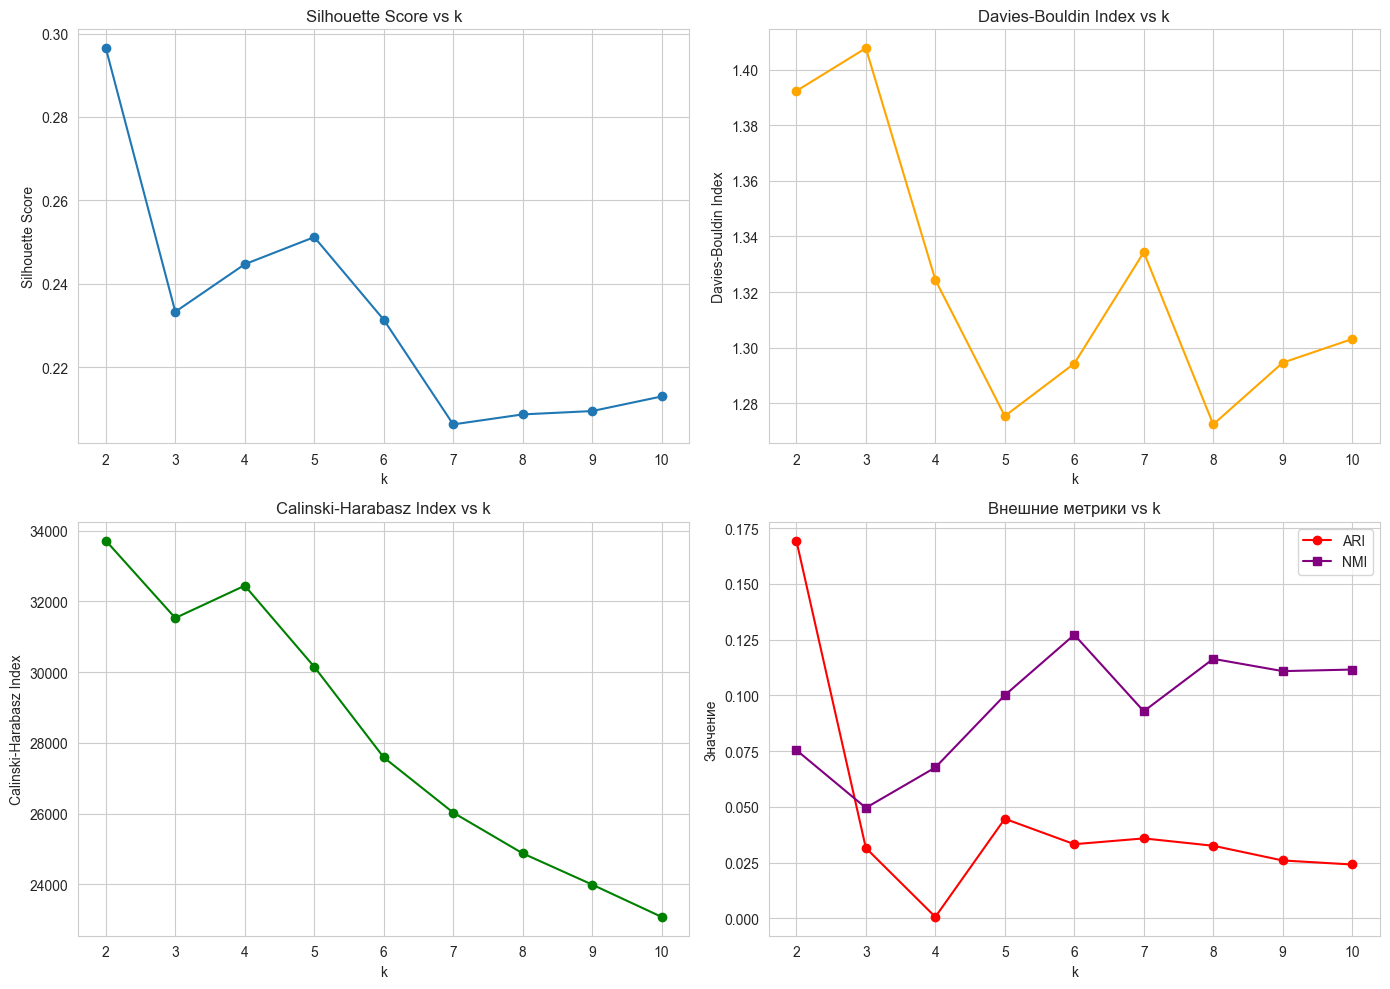

In [23]:
k_range = range(2, 11)
metrics_k = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    
    sil = silhouette_score(X, labels)
    db = davies_bouldin_score(X, labels)
    ch = calinski_harabasz_score(X, labels)
    
    ari = adjusted_rand_score(true_labels, labels)
    nmi = normalized_mutual_info_score(true_labels, labels)
    
    metrics_k.append({
        'k': k,
        'Silhouette': round(sil, 4),
        'Davies-Bouldin': round(db, 4),
        'Calinski-Harabasz': int(ch),
        'ARI': round(ari, 4),
        'NMI': round(nmi, 4)
    })

metrics_df_k = pd.DataFrame(metrics_k)
print(metrics_df_k.to_string(index=False))

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

axes[0].plot(k_range, metrics_df_k['Silhouette'], marker='o')
axes[0].set_xlabel('k')
axes[0].set_ylabel('Silhouette Score')
axes[0].set_title('Silhouette Score vs k')
axes[0].grid(True)

axes[1].plot(k_range, metrics_df_k['Davies-Bouldin'], marker='o', color='orange')
axes[1].set_xlabel('k')
axes[1].set_ylabel('Davies-Bouldin Index')
axes[1].set_title('Davies-Bouldin Index vs k')
axes[1].grid(True)

axes[2].plot(k_range, metrics_df_k['Calinski-Harabasz'], marker='o', color='green')
axes[2].set_xlabel('k')
axes[2].set_ylabel('Calinski-Harabasz Index')
axes[2].set_title('Calinski-Harabasz Index vs k')
axes[2].grid(True)

axes[3].plot(k_range, metrics_df_k['ARI'], marker='o', color='red', label='ARI')
axes[3].plot(k_range, metrics_df_k['NMI'], marker='s', color='purple', label='NMI')
axes[3].set_xlabel('k')
axes[3].set_ylabel('Значение')
axes[3].set_title('Внешние метрики vs k')
axes[3].legend()
axes[3].grid(True)

plt.tight_layout()
plt.show()

## Вывод о влиянии параметра k для K-means:

1. Оптимальное k по внутренним метрикам:

- Silhouette максимален при k=2 (0.297), затем монотонно снижается

- Davies-Bouldin минимален при k=5 (1.275)

- Calinski-Harabasz максимален при k=2 (33716), резко падает с ростом k

2. Оптимальное k по внешним метрикам (сравнение с диабетом):

- ARI максимален при k=2 (0.169), при k≥3 близок к 0 (случайное совпадение)

- NMI достигает максимума при k=6 (0.127), но значения очень низкие

3. Ключевые наблюдения:

- k=2 даёт наилучший силуэт и Calinski-Harabasz, что подтверждает наше ранее выбранное значение

- При увеличении k качество кластеризации снижается по большинству метрик

- Низкие значения ARI при k>2 показывают, что дополнительные кластеры не соответствуют диагнозу диабета

#### Вывод:
Выбор k=2 для K-means является оптимальным: обеспечивает наилучшее внутреннее качество и максимальное (хоть и слабое) соответствие медицинскому диагнозу. Увеличение количества кластеров приводит к излишней фрагментации данных без улучшения качества.

#### Интерпретация: 

Данные естественным образом делятся на две основные группы, что соответствует базовой медицинской логике разделения на группу риска и условно здоровых пациентов.

## Визуализация кластеров с использованием PCA

Используем PCA для снижения размерности до 2D/3D и визуализируем кластеры от обоих методов

Доля объяснённой дисперсии PCA:
PC1: 0.473
PC2: 0.222
Суммарно: 0.695


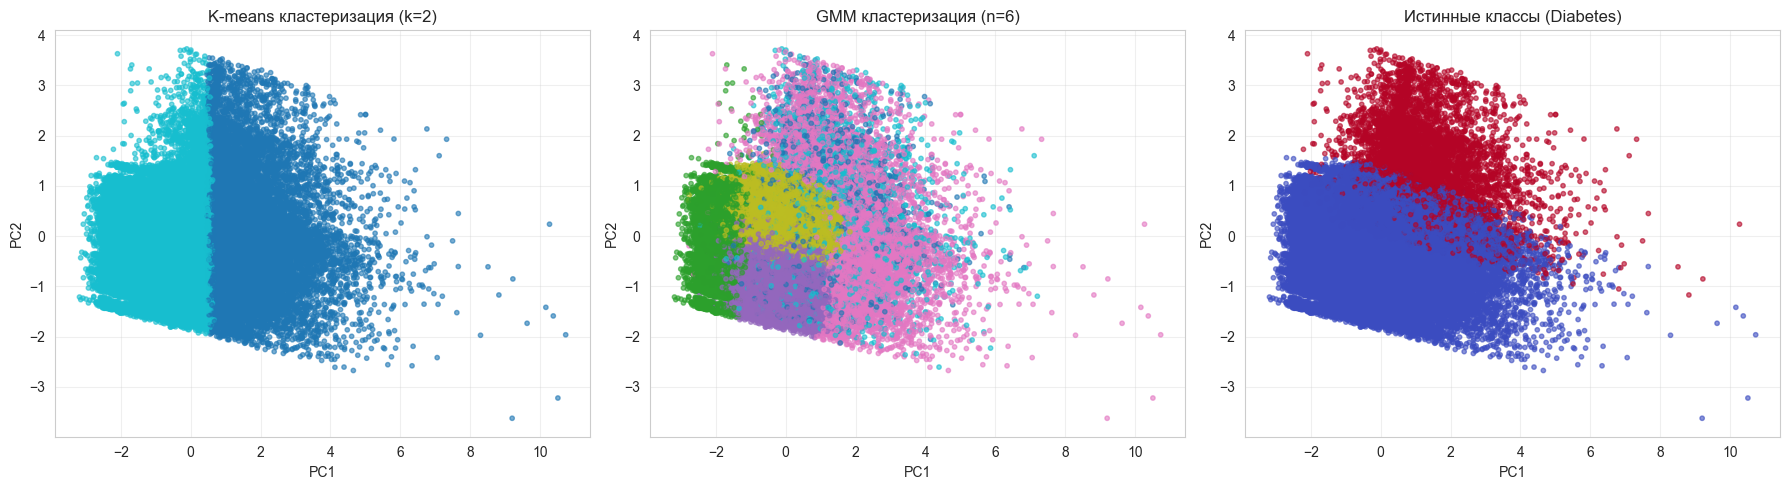

In [25]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['KMeans_Cluster'] = kmeans_labels
pca_df['GMM_Cluster'] = gmm_labels
pca_df['Diabetes'] = df['diabetes'].values

print("Доля объяснённой дисперсии PCA:")
print(f"PC1: {pca.explained_variance_ratio_[0]:.3f}")
print(f"PC2: {pca.explained_variance_ratio_[1]:.3f}")
print(f"Суммарно: {pca.explained_variance_ratio_.sum():.3f}")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# K-means кластеры
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, 
                          cmap='tab10', s=10, alpha=0.6)
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_title('K-means кластеризация (k=2)')
axes[0].grid(True, alpha=0.3)

# GMM кластеры
scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=gmm_labels, 
                          cmap='tab10', s=10, alpha=0.6)
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].set_title('GMM кластеризация (n=6)')
axes[1].grid(True, alpha=0.3)

# Истинные классы 
scatter3 = axes[2].scatter(X_pca[:, 0], X_pca[:, 1], c=df['diabetes'], 
                          cmap='coolwarm', s=10, alpha=0.6)
axes[2].set_xlabel('PC1')
axes[2].set_ylabel('PC2')
axes[2].set_title('Истинные классы (Diabetes)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Анализ центров кластеров K-means и интерпретация групп

In [26]:
centers_original = scaler.inverse_transform(kmeans_final.cluster_centers_)
centers_original_df = pd.DataFrame(centers_original, columns=numeric_features, 
                                   index=[f'Кластер {i}' for i in range(2)])

print("Центры кластеров:")
print(centers_original_df.round(2))

print("\nСравнение с общими средними по датасету:")
means_overall = df[numeric_features].mean()
comparison = pd.DataFrame({
    'Общее среднее': means_overall.round(2),
    'Кластер 0': centers_original_df.iloc[0].round(2),
    'Кластер 1': centers_original_df.iloc[1].round(2)
})
print(comparison)

print("\nРазница между кластрами:")
diff = centers_original_df.iloc[0] - centers_original_df.iloc[1]
print(diff.round(2))

Центры кластеров:
             age    bmi  HbA1c_level  blood_glucose_level  hypertension  \
Кластер 0  50.83  36.36         5.84               150.40          0.15   
Кластер 1  39.32  24.73         5.44               134.52          0.05   

           heart_disease  
Кластер 0           0.07  
Кластер 1           0.03  

Сравнение с общими средними по датасету:
                     Общее среднее  Кластер 0  Кластер 1
age                          41.89      50.83      39.32
bmi                          27.32      36.36      24.73
HbA1c_level                   5.53       5.84       5.44
blood_glucose_level         138.06     150.40     134.52
hypertension                  0.07       0.15       0.05
heart_disease                 0.04       0.07       0.03

Разница между кластрами:
age                    11.51
bmi                    11.62
HbA1c_level             0.40
blood_glucose_level    15.88
hypertension            0.10
heart_disease           0.04
dtype: float64


### Интерпретация кластеров K-means:

#### Кластер 0 (22% пациентов, "Группа риска"):

- Возраст: 50.8 лет (значительно выше среднего 41.9)

- ИМТ: 36.4 (ожирение I степени, намного выше среднего 27.3)

- Показатели сахара: HbA1c 5.84%, глюкоза 150.4 мг/дл (повышенные)

- Сопутствующие заболевания: гипертония 15%, сердечные заболевания 7% (в 2-3 раза выше среднего)

#### Кластер 1 (78% пациентов, "Условно здоровые"):

- Возраст: 39.3 года (ниже среднего)

- ИМТ: 24.7 (нормальный, близок к верхней границе)

- Показатели сахара: HbA1c 5.44%, глюкоза 134.5 мг/дл (близко к норме)

- Сопутствующие заболевания: гипертония 5%, сердечные заболевания 3% (ниже среднего)

## Итоговое сравнение результатов K-means и Gaussian Mixture

##### 1. Структура кластеров:

- K-means: Чёткое бинарное разделение (78%/22%). Простая, интерпретируемая структура.

- GMM: 6 перекрывающихся кластеров разного размера (от 4k до 41k). Более сложная, детализированная структура.

##### 2. Качество кластеризации (внутренние метрики):

- Silhouette: K-means 0.30 vs GMM 0.20 — K-means создаёт более определённые кластеры

- Davies-Bouldin: K-means 1.39 vs GMM 1.84 — кластеры K-means лучше разделены

- Calinski-Harabasz: K-means 33716 vs GMM 16147 — K-means даёт лучшее соотношение меж-/внутрикластерной дисперсии

##### 3. Соответствие диагнозу диабета (внешние метрики):

- ARI: K-means 0.17 vs GMM 0.07 — кластеры K-means слабо, но лучше соотносятся с диагнозом

- NMI: K-means 0.08 vs GMM 0.10 — примерное равенство

- Rand Index: K-means 0.67 vs GMM 0.39 — K-means показывает лучшее согласование

##### 4. Интерпретируемость:

- K-means: Ясная медицинская интерпретация: "группа риска" (ожирение, возраст, повышенный сахар) vs "условно здоровые".

- GMM: Выявляет подгруппы внутри основных категорий, но интерпретация сложнее. Возможные подгруппы: молодые с ожирением, пожилые с нормальным весом но повышенным сахаром и т.д.

##### 5. Устойчивость к структуре данных:

- K-means: Предполагает сферические кластеры одинакового размера — подходит для наших данных, где есть доминирующая группа.

- GMM: Может моделировать эллипсоидальные кластеры разной формы и размера — лучше подходит для сложных перекрывающихся распределений.

# Заключение

##### K-means показал себя лучше для данной задачи: даёт более качественное (по внутренним метрикам) и клинически интерпретируемое разбиение. Простое разделение на две группы соответствует базовой медицинской логике.

##### GMM выявил более тонкую структуру данных, что полезно для исследовательских целей, но полученные кластеры менее компактны и их сложнее интерпретировать в клиническом контексте.

##### Для практического применения в медицине K-means с k=2 рекомендуется как более интерпретируемый метод. Для анализа подгрупп пациентов можно использовать GMM, но потребуется дополнительная экспертиза для интерпретации кластеров.